# ML Course 2024 |  Medical Expenses Prediction Challenge

This notebook should serve as a starting point to work on the project. Please read the project description first.

# Set team ID
Important: set your Team ID here. You can find it in CMS.

In [1]:
team_id = '123' #put your team id here

# [Colab only] Connect to your Google Drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd "/content/drive/MyDrive/path/to/your/project"

# Imports

[Colab only] Note: if you need to install any packages, run a code cell with content `!pip install packagename`

In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as skm
from scipy import stats
from scipy.stats import norm, skew  # for some statistics
from sklearn import linear_model, preprocessing
from sklearn.metrics import make_scorer
from sklearn.model_selection import ShuffleSplit

from models.model import Dataset
from utils import metrics as my_metrics
from utils import scorers, tuning
from utils.config import CUML_INSTALLED, DPI, NOTEBOOK_STYLE, PAPER_STYLE
from utils.helpers import (
    load_from_cache,
    make_pretty_table,
    parse_cv_results,
    parsed_cv_results_to_df,
    safe_latex_context,
    save_to_cache,
)

# Use cuML to use GPU-accelerated models
USE_CUML = True

if CUML_INSTALLED and USE_CUML:
    from cuml.common.device_selection import get_global_device_type, set_global_device_type
    from cuml.kernel_ridge import KernelRidge
    from cuml.linear_model import Lasso, LinearRegression, Ridge
    from cuml.svm import SVR

    set_global_device_type("gpu")

    print("cuML's default execution device:", get_global_device_type())
else:
    from sklearn.kernel_ridge import KernelRidge
    from sklearn.linear_model import Lasso, LinearRegression, Ridge
    from sklearn.svm import SVR

# Constants that define the classification and regression targets
CLF_TARGET = "UTILIZATION"
REG_TARGET = "TOT_MED_EXP"

cuML's default execution device: DeviceType.device


# Load Data

In a first step, we load the provided training data from the csv file

In [5]:
import pandas as pd

df_train = pd.read_csv('data/train.csv')
print("The loaded dataset has {} rows and {} columns".format(df_train.shape[0], df_train.shape[1]))

The loaded dataset has 15000 rows and 110 columns


In [6]:
df_train.head()

,RACE,SEX,PANEL,WEIGHT,STUDENT_STAT,MIL_ACTIV_DUTY,HON_DISCHARGE,HEALTH_STAT,MENTAL_HLTH,CHRON_BRONCH,...,NUM_PRESCR_MEDS,DIFFIC_HEAR,DIFFIC_SEE,SMOK,OVR_FEEL_14,MENTAL_HLTH_SCR,PHY_HLTH_SCR,OVR_FEEL_30,TOT_MED_EXP,UTILIZATION
0,Non-White,1,19,7205.036720,-1,2,2,2,2,2,...,0,2,2,2,1,43.82,61.41,3,0,LOW
1,White,1,20,5501.113581,-1,4,2,1,1,2,...,12,2,2,2,0,60.12,54.80,0,240,LOW
2,White,1,20,16797.708379,-1,4,1,3,1,2,...,20,2,2,2,0,60.35,30.08,0,791,LOW
3,Non-White,2,19,3605.218411,-1,2,2,3,3,2,...,20,2,2,2,0,58.32,50.22,0,272,LOW
4,Non-White,1,19,11223.127404,1,2,2,1,2,2,...,3,2,2,2,0,62.39,56.71,0,1264,LOW


# Data exploration

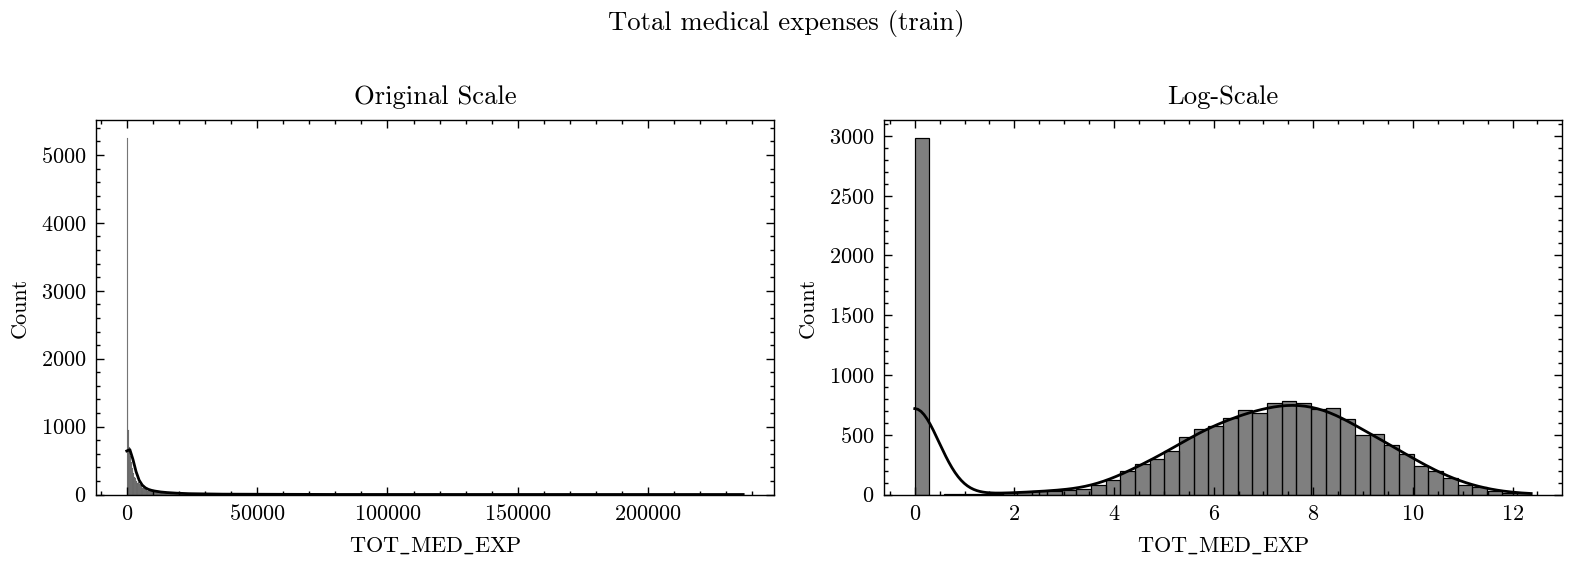

In [7]:
# Plotting
with plt.style.context(PAPER_STYLE), safe_latex_context(df_train) as safe:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=DPI)
    sns.histplot(df_train[REG_TARGET], kde=True, ax=ax1)
    ax1.set_title("Original Scale")
    ax1.set_xlabel(safe("TOT_MED_EXP"))

    sns.histplot(np.log1p(df_train[REG_TARGET]), kde=True, ax=ax2)
    ax2.set_title("Log-Scale")
    ax2.set_xlabel(safe("TOT_MED_EXP"))

    fig.suptitle("Total medical expenses (train)", y=0.95)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

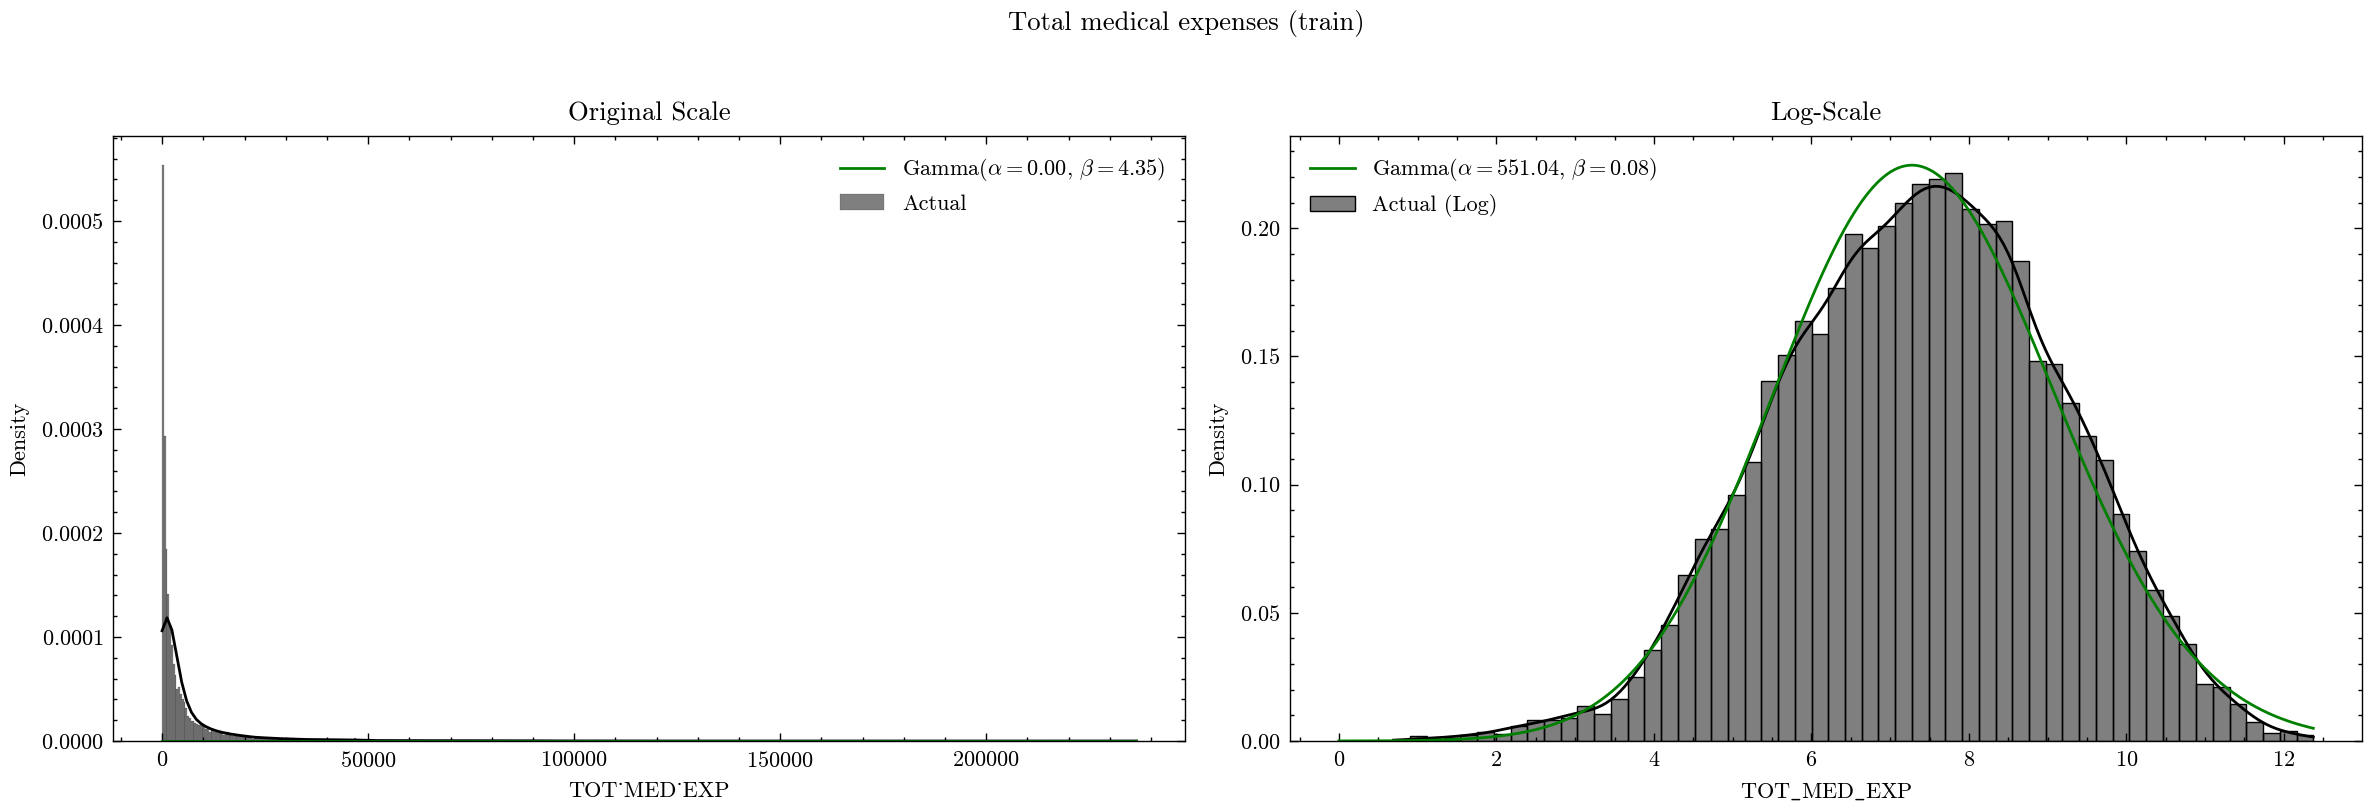

In [8]:

df_train_copy = df_train.copy()
df_train_copy.drop(df_train_copy[df_train_copy["TOT_MED_EXP"] == 0].index, inplace=True)
df_train_copy.reset_index(drop=True, inplace=True)

# Assuming df_train and REG_TARGET are defined
data = df_train_copy[REG_TARGET]
log_data = np.log1p(data)

# Fit Gamma distribution to original data
gamma_params = stats.gamma.fit(data)
gamma_dist = stats.gamma(*gamma_params)

# Fit Gamma distribution to log-transformed data
log_gamma_params = stats.gamma.fit(log_data)
log_gamma_dist = stats.gamma(*log_gamma_params)

# Plotting
with plt.style.context(PAPER_STYLE), safe_latex_context(df_train_copy) as safe:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=DPI)

    # Original Scale
    sns.histplot(data, kde=True, ax=ax1, stat="density", label="Actual")
    x_range = np.linspace(0, data.max(), 1000)
    ax1.plot(
        x_range,
        gamma_dist.pdf(x_range),
        "g-",
        label=r"Gamma($\alpha=$" + f"{gamma_params[0]:.2f}, " + r"$\beta=$" + f"{gamma_params[2]:.2f})",
    )
    ax1.set_title("Original Scale")
    ax1.set_xlabel("TOT_MED_EXP")
    ax1.legend()

    # Log-Scale
    sns.histplot(log_data, kde=True, ax=ax2, stat="density", label="Actual (Log)")
    x_range_log = np.linspace(0, log_data.max(), 1000)
    ax2.plot(
        x_range_log,
        log_gamma_dist.pdf(x_range_log),
        "g-",
        label=r"Gamma($\alpha=$" + f"{log_gamma_params[0]:.2f}, " + r"$\beta=$" + f"{log_gamma_params[2]:.2f})",
    )
    ax2.set_title("Log-Scale")
    ax2.set_xlabel(safe("TOT_MED_EXP"))
    ax2.legend()

    fig.suptitle("Total medical expenses (train)", y=1.02)
    fig.tight_layout()
    plt.show()

# Linear regression

In this part, we will solve an linear regression task to predict our target `TOT_MED_EXP`, i.e. total medical expences, using the other features.


In its simplest form, predictions of a linear regression model can be summarized as

$$
\hat{y} = \mathbf{w}^T \mathbf{x} = f(\mathbf{x},\mathbf{w})
$$

which can be optimized using the cost function

$$
\mathbf{w}^{*}=\underset{\mathbf{w}}{\arg \min } \frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-f\left(\mathbf{x}_{i}, \mathbf{w}\right)\right)^{2}
$$

### Process the data

In [9]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

df_train["RACE"] = LabelEncoder().fit_transform(df_train["RACE"])

# Drop rows with 0 or negative values in the target column
df_train_without_0 = df_train.drop(df_train.index[(df_train["TOT_MED_EXP"] <= 0)])
df_train_without_0.reset_index(drop=True, inplace=True)


def get_X_y_train_val_split(df: pd.DataFrame, apply_func_y: callable = None) -> tuple:
    if apply_func_y is not None:
        y = apply_func_y(df["TOT_MED_EXP"])
    else:
        y = df["TOT_MED_EXP"]

    X = df.drop(columns=["TOT_MED_EXP", "UTILIZATION"])

    # Split X and y for training and validation purposes
    return train_test_split(X, y, test_size=0.2, random_state=42)


# Split X and y for training and validation purposes
X_train_c, X_val_c, y_train_c, y_val_c = get_X_y_train_val_split(df_train)
X_train_w0, X_val_w0, y_train_w0, y_val_w0 = get_X_y_train_val_split(df_train_without_0, np.log1p)

print("Complete df_train: ")
print(
    f"X_train: {X_train_c.shape}, y_train: {y_train_c.shape}, X_val: {X_val_c.shape}, y_val: {y_val_c.shape}"
)
print("\nWithout 0 or negative values in TOT_MED_EXP: ")
print(
    f"X_train: {X_train_w0.shape}, y_train: {y_train_w0.shape}, X_val: {X_val_w0.shape}, y_val: {y_val_w0.shape}"
)

Complete df_train: 
X_train: (12000, 108), y_train: (12000,), X_val: (3000, 108), y_val: (3000,)

Without 0 or negative values in TOT_MED_EXP: 
X_train: (9616, 108), y_train: (9616,), X_val: (2404, 108), y_val: (2404,)


In [10]:
import time

from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X, y, X_val, y_val = X_train_w0, y_train_w0, X_val_w0, y_val_w0

start_time = time.time()
lasso_lars_ic = make_pipeline(StandardScaler(), LassoLarsIC(criterion="aic")).fit(X, y)
fit_time = time.time() - start_time

False


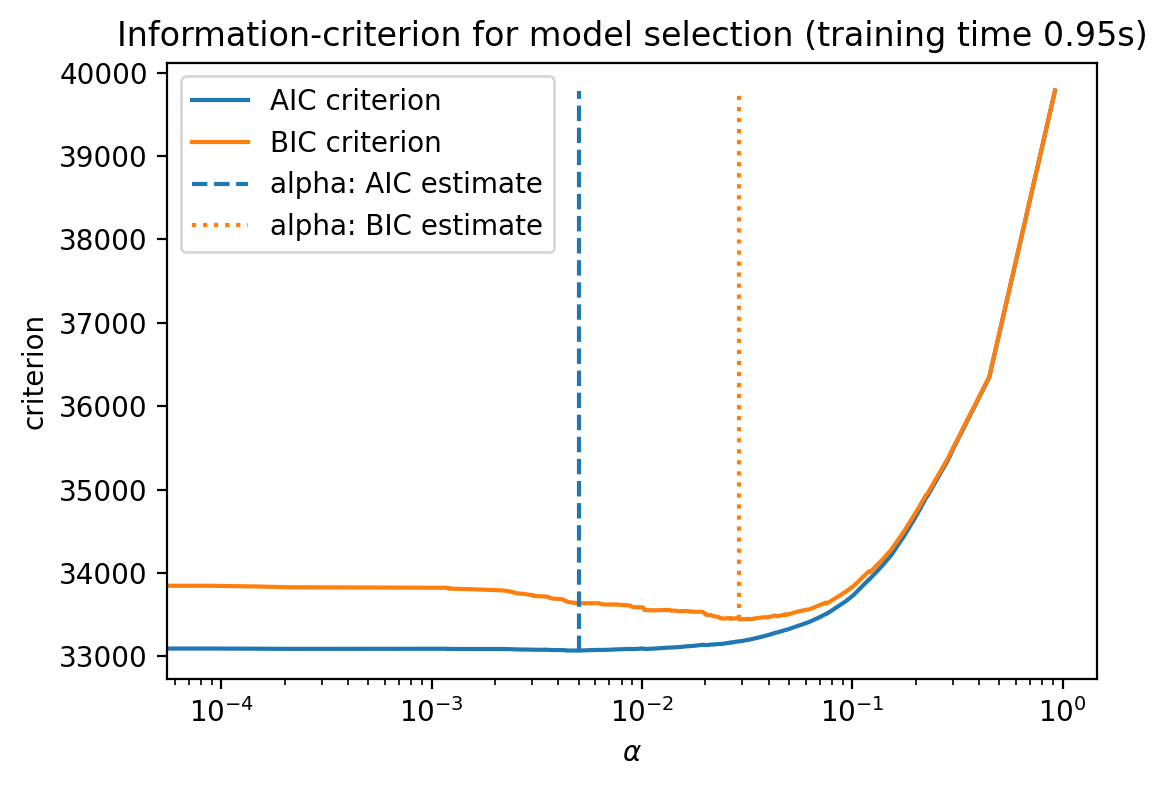

In [11]:
def zou_et_al_criterion_rescaling(criterion, n_samples, noise_variance):
    """Rescale the information criterion to follow the definition of Zou et al."""
    return criterion - n_samples * np.log(2 * np.pi * noise_variance) - n_samples

aic_criterion = zou_et_al_criterion_rescaling(
    lasso_lars_ic[-1].criterion_,
    X.shape[0],
    lasso_lars_ic[-1].noise_variance_,
)

results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

index_alpha_path_aic = np.flatnonzero(
    lasso_lars_ic[-1].alphas_ == lasso_lars_ic[-1].alpha_
)[0]

lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y)

bic_criterion = zou_et_al_criterion_rescaling(
    lasso_lars_ic[-1].criterion_,
    X.shape[0],
    lasso_lars_ic[-1].noise_variance_,
)

results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

index_alpha_path_bic = np.flatnonzero(
    lasso_lars_ic[-1].alphas_ == lasso_lars_ic[-1].alpha_
)[0]

print(index_alpha_path_aic == index_alpha_path_bic)

fig, ax = plt.subplots(figsize=(6, 4))
results.plot(ax=ax)
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="dotted",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection (training time {fit_time:.2f}s)"
)
plt.show()

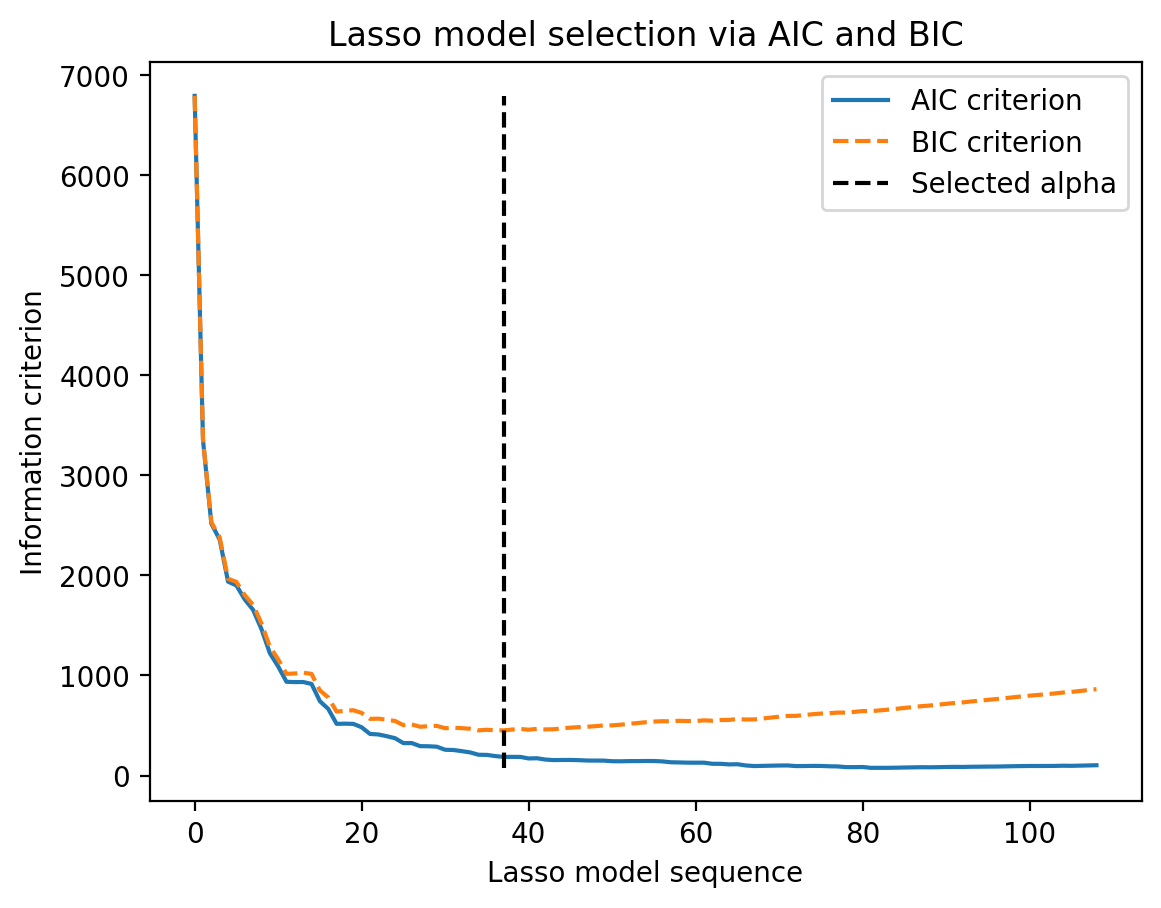

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(aic_criterion, color="tab:blue", label="AIC criterion")
plt.plot(bic_criterion, color="tab:orange", label="BIC criterion", linestyle="--")
plt.vlines(
    index_alpha_path_bic,
    aic_criterion.min(),
    aic_criterion.max(),
    color="black",
    linestyle="--",
    label="Selected alpha",
)
plt.legend()
plt.ylabel("Information criterion")
plt.xlabel("Lasso model sequence")
_ = plt.title("Lasso model selection via AIC and BIC")
plt.show()

In [13]:
def print_metrics(y_true, y_pred):
    rmse = np.sqrt(skm.mean_squared_error(y_true, y_pred))
    mae = skm.mean_absolute_error(y_true, y_pred)
    median_se = np.sqrt(np.median((y_true - y_pred)**2))
    median_ae = np.median(np.abs(y_true - y_pred))
    
    print(f"\tRMSE: {rmse:.2f}")
    print(f"\tMAE: {mae:.2f}")
    print(f"\tsqrt(median((y-pred)**2)): {median_se:.2f}")
    print(f"\tmedian(abs(y-pred)): {median_ae:.2f}")

def evaluate_model(model, X_train, y_train, X_val, y_val):
    for split_name, (X, y) in [("training", (X_train, y_train)), ("validation", (X_val, y_val))]:
        print(f"Split: {split_name}")
        y_pred = model.predict(X)
        print_metrics(y, y_pred)
    print("\n")

evaluate_model(lasso_lars_ic, X, y, X_val, y_val)

Split: training
	RMSE: 1.35
	MAE: 1.06
	sqrt(median((y-pred)**2)): 0.86
	median(abs(y-pred)): 0.86
Split: validation
	RMSE: 1.38
	MAE: 1.08
	sqrt(median((y-pred)**2)): 0.87
	median(abs(y-pred)): 0.87




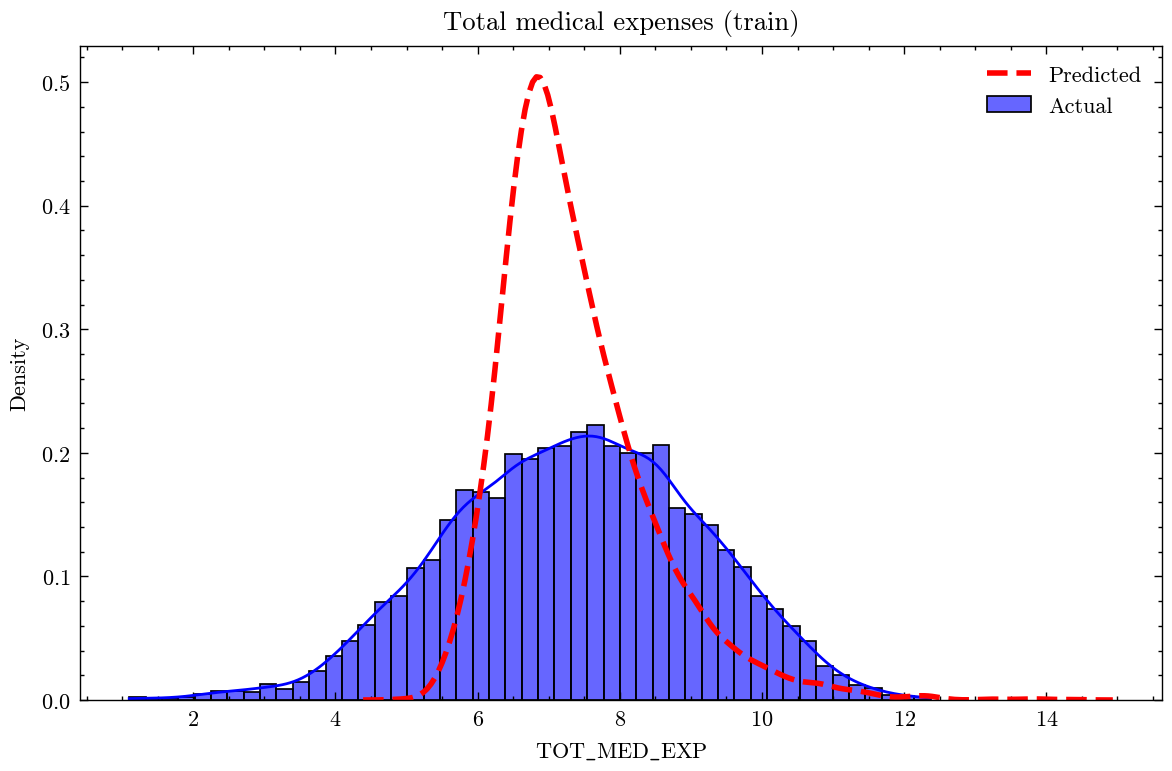

In [14]:
# Use your actual X_train data to get predictions
y_pred = lasso_lars_ic.predict(X)

# Rescale the target variable back to its original scale
# y = df_train.inverse_transform(y, column_of_origin=df_train.target)
# y_pred = df_train.inverse_transform(y_pred, column_of_origin=df_train.target)

# Plot
with plt.style.context(PAPER_STYLE), safe_latex_context(df_train) as safe:
    fig, ax = plt.subplots(figsize=(6, 4), dpi=DPI)
    
    # Plot the actual distribution
    sns.histplot(y, kde=True, ax=ax, stat='density', label='Actual', color='blue', alpha=0.6)
    
    # Plot the predicted distribution
    sns.kdeplot(y_pred, ax=ax, label=f'Predicted', color='red', linewidth=2)
    
    ax.set_title("Total medical expenses (train)")
    ax.set_xlabel(safe("TOT_MED_EXP"))
    ax.set_ylabel("Density")
    ax.legend()
    
    fig.tight_layout()
    plt.show()

### Train a linear regression model

In [15]:
import numpy as np
import pandas as pd
from sklearn.linear_model import HuberRegressor, LinearRegression, TweedieRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
import sklearn.metrics as skm
from utils.hurdle import HurdleRegression

def create_pipeline(regressor, scaler=StandardScaler()):
    if scaler is None:
        return Pipeline([("regressor", regressor)])
    return Pipeline([("scaler", scaler), ("regressor", regressor)])

def evaluate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    return -scores.mean()

def print_metrics(y_true, y_pred):
    rmse = np.sqrt(skm.mean_squared_error(y_true, y_pred))
    mae = skm.mean_absolute_error(y_true, y_pred)
    median_se = np.sqrt(np.median((y_true - y_pred)**2))
    median_ae = np.median(np.abs(y_true - y_pred))
    
    print(f"\tRMSE: {rmse:.2f}")
    print(f"\tMAE: {mae:.2f}")
    print(f"\tsqrt(median((y-pred)**2)): {median_se:.2f}")
    print(f"\tmedian(abs(y-pred)): {median_ae:.2f}")

models = {
    "LinearRegression": LinearRegression(),
    "HuberRegressor": HuberRegressor(max_iter=3000, alpha=1),
    "TweedieRegressor": TweedieRegressor(power=1.1, alpha=1.2915496650148826, link="log", max_iter=5000),
    "HurdleRegression": HurdleRegression(reg_name="LGBMRegressor", clf_name="LGBMClassifier"),
}

results = {}

for name, model in models.items():
    pipe = create_pipeline(model, scaler=RobustScaler())
    cv_rmse = evaluate_model(pipe, X_train, y_train)
    
    pipe.fit(X_train, y_train)
    
    results[name] = {
        "pipeline": pipe,
        "cv_rmse": cv_rmse
    }
    
    print(f"Model: {name}")
    print(f"Cross-validation RMSE: {cv_rmse:.2f}")
    
    for split_name, (X, y) in [("training", (X_train, y_train)), ("validation", (X_val, y_val))]:
        print(f"Split: {split_name}")
        y_pred = pipe.predict(X)
        print_metrics(y, y_pred)
    print("\n")

# Find the best model based on validation RMSE
best_model = min(results, key=lambda x: results[x]["cv_rmse"])
print(f"Best model based on cross-validation RMSE: {best_model}")

# You can access the best model's pipeline with:
reg = results[best_model]["pipeline"] # best_pipeline = results[best_model]["pipeline"]

NameError: name 'X_train' is not defined

In [ ]:
log_gamma_params[0]

In [ ]:
y_pred = reg.predict(X)

# Calculate residuals
residuals = y - y_pred

with plt.style.context(PAPER_STYLE):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2))

    # Plot Actual vs Predicted
    ax1.scatter(y, y_pred, s=5)
    ax1.plot(
        [min(y), max(y)], [min(y_pred), max(y_pred)], color="red", linestyle="--", label="Ideal Fit"
    )
    ax1.set_xlabel("Actual Values")
    ax1.set_ylabel("Predicted Values")
    ax1.legend()
    ax1.set_title("Actual vs Predicted")

    # Plot Residuals
    ax2.scatter(y, residuals, s=5)
    ax2.hlines(y=0, xmin=min(y), xmax=max(y), colors="red", linestyles="--", label="Zero Error")
    ax2.set_xlabel("Actual Values")
    ax2.set_ylabel("Residuals")
    ax2.legend()
    ax2.set_title("Residuals")
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import TweedieRegressor
import numpy as np

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('tweedie', TweedieRegressor())
])

# Define the parameter grid
param_grid = {
    'tweedie__power': np.linspace(1.1, 2.0, 10),  # Values between 1 and 2
    'tweedie__alpha': np.logspace(-3, 1, 10),     # Regularization strength
    'tweedie__link': ['log', 'identity'],         # Link function
    'tweedie__max_iter': [1000, 5000]             # Max iterations
}

# Create the grid search object
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-2  # Use all available cores
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best negative MSE:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_train)

# If you used log1p transformation, apply it to the predictions
y_pred_log = np.log1p(y_pred)

### Evaluate the linear regression model

In [ ]:
import sklearn.metrics as skm
import numpy as np

datasets = {
    "training data": [X_train, y_train],
    "validation data": [X_val, y_val]
}

for split_name, dataset in datasets.items():
    print(f'Split: {split_name}\n')

    X_i, y_i = dataset
    y_pred = reg.predict(X_i)

    rmse = np.sqrt(skm.mean_squared_error(y_i, y_pred))
    print(f"\tRMSE: {rmse:.2f}")

    mae = skm.mean_absolute_error(y_i, y_pred)
    print(f"\tMAE: {mae:.2f}")

    # These might also be helpful to look at. Think about why!
    print("\tsqrt(median((y-pred)**2)):",np.sqrt(np.median((y_i-y_pred)**2)))
    print("\tmedian(abs(y-pred)):",np.median(abs(y_i-y_pred)))

    print('\n\n')

### Export test set predictions for regression task

At this point, we can use our model to predict the medical expenses from the test sets. The following cell shows an example on how to do this.

You must save your predictions (`y_hat`) to a file and name the file in the following format:

`<TEAM_ID>__<SPLIT>__reg_pred.npy`

Make sure that:

`<TEAM_ID>` is your team id as given in CMS.

`<SPLIT>` is "test_public" during the semester and "test_private" for the final submission. We will write an announcement to CMS once the test_private dataset is available to download.

In [ ]:
# Run this to save a file with your predictions on the test set to be submitted
split = 'test_public' # replace by 'test_private' for FINAL submission

df_test =  pd.read_csv(f'data/{split}.csv')

# Process data
df_test['RACE'] = LabelEncoder().fit_transform(df_test['RACE'])

y_hat = reg.predict(df_test)

# Save the results with the format <TEAM_ID>__<SPLIT>__reg_pred.npy

folder = './'
np.save(os.path.join(folder, f'{team_id}__{split}__reg_pred.npy'), y_hat) # Note the double underscores '__' in the filename

# Linear classification

In this part, we will train a simple linear classification model to predict our target `UTILIZATION`.


In [ ]:
from sklearn import linear_model
from sklearn import preprocessing
import numpy as np

We will first change our targets (classes: LOW, HIGH) to numeric targets. Then, we solve a logistic regression problem by minimizing the binary cross-entropy function

$$
J(\theta) = -\frac{1}{n} \sum_{i=1}^{n} \left( y_i \log(p_{\theta}(\hat{y}=1 | \mathbf{x}_i)) + (1 - y_i) \log(p_{\theta}(\hat{y}=0 | \mathbf{x}_i)) \right)
$$

where $y_i \in \{0, 1\}$ and $p_{\theta}(\hat{y}=k | \mathbf{x}_i)$ is the probability assigned by our model to class $k$ having observed features $\mathbf{x}_i$.

0 refers to HIGH, and 1 refers to LOW

### Process the data

In [ ]:
df_train =  pd.read_csv(f'data/train.csv')

y = df_train['UTILIZATION']

df_train.drop(columns=['UTILIZATION','TOT_MED_EXP'])

le = preprocessing.LabelEncoder()
df_test['RACE'] = le.fit_transform(df_test['RACE'])

y = le.fit_transform(y) # maps HIGH to 0 and LOW to 1

print(f'Original classes {le.classes_}')
print(f'Corresponding numeric classes {le.transform(le.classes_)}')


print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}", f", unique entries in y: {np.unique(y)}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# These hyperparameters are just placeholders, choosen without much care. For a good LogisticRegression baseline, play with them a bit.
clf = linear_model.LogisticRegression(penalty=None,
                                      dual=False,
                                      tol=0.0001,
                                      C=1.0,
                                      fit_intercept=True,
                                      intercept_scaling=1,
                                      class_weight=None, # None, balanced
                                      random_state=None,
                                      solver='lbfgs',
                                      max_iter=1500,
                                      multi_class='auto',
                                      verbose=0,
                                      warm_start=False,
                                      n_jobs=None,
                                      l1_ratio=None
                                     )

### Fit the model by using training data

In [ ]:
clf = clf.fit(X_train, y_train)


Now evaluate your model. Check the appendix for details on micro, macro and weighted averaging

In [ ]:
datasets = {
    "training data": [X_train, y_train],
    "validation data": [X_val, y_val]
}

for split_name, dataset in datasets.items():
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f'\nSplit: {split_name}')

    print(skm.classification_report(y_i, y_pred))

At this point, we can use our model to predict healthcare utilization on the test set.

We again need to follow a specific namim format when saving the predictions. Similarly to before, the name of the file should be `<TEAM_ID>__<SPLIT>__clf_pred.npy`.



In [ ]:
# Run this to save a file with your predictions on the test set to be submitted

split = 'test_public' # replace by 'test_private' for FINAL submission

df_test =  pd.read_csv(f'data/{split}.csv')

# Process data
df_test['RACE'] = LabelEncoder().fit_transform(df_test['RACE'])

y_hat = clf.predict(df_test)

# Save the results with the format <TEAM_ID>__<SPLIT>__clf_pred.npy

folder = './'
np.save(os.path.join(folder, f'{team_id}__{split}__clf_pred.npy'), y_hat)

# Submission to CMS

Put your .npy files for both regression and classification tasks in the same zip file. Please name the file as `<TEAM_ID>.zip` (e.g. `123.zip`) and upload it to CMS system. It is essential that the files inside the .zip are named as follow:

`<TEAM_ID>__<SPLIT>__reg_pred.npy` \
`<TEAM_ID>__<SPLIT>__clf_pred.npy`

Above, `<SPLIT>` should correspond to `test_public` for the leaderboard and `test_private` for the final submission.
As long as the `test_private.csv` data file is not released yet, the zip will contain only two files.


### Appendix: Reminders about macro and micro averaging:

When evaluating a classification model using `skm.classification_report(y_i, y_pred)` as done above, we get a macro and a weighted average.

In the context of computing F1-score, "macro" and "micro" averaging are two commonly used techniques to aggregate the per-class F1-scores.

**Micro-average**: Compute the F1-score globally by counting the total true positives, false negatives, and false positives over all classes, and then calculating precision, recall, and F1-score using these aggregated values.

**Macro-average**: Calculate the F1-score for each class separately, and then take the average of these per-class F1-scores.

The main difference between these two techniques is the way they treat class imbalance. Micro-average treats all classes equally, regardless of their size, while macro-average treats each class equally, regardless of the number of samples in that class.

Micro-average is often used when we care about overall performance across all classes, and we want to give more weight to the performance on larger classes. In contrast, macro-average is often used when we want to evaluate the performance on each class separately and give equal weight to each class.


In addition to micro and macro averaging, there is another common technique for computing the F1-score called **weighted averaging**.

**Weighted averaging** is similar to macro averaging in that it computes the per-class F1-score and then takes the average of these scores. However, unlike macro averaging, weighted averaging takes into account the number of samples in each class when computing the average. Specifically, the weighted average is computed as follows:

- Compute the F1-score for each class separately.
- Compute the weight for each class as the number of samples in that class divided by the total number of samples.
- Compute the weighted average of the per-class F1-scores, where each per-class F1-score is weighted by the weight of that class.

The weighted average is commonly used when the dataset is imbalanced, meaning that some classes have many more samples than others. In such cases, using the simple average (macro-average) would give too much weight to the smaller classes, while using micro-average would give too much weight to the larger classes. The weighted average strikes a balance between these two approaches by giving more weight to the classes with more samples while still taking into account the performance of all classes.


When computing the F1 score for the leaderboard and the final challenge results, we will be using the macro averaging strategy.